In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RS = 1

In [3]:
sns.set_theme(style="white")

In [4]:
n_samples = 1500
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=170)
X = X @ transformation

---

## Conceitos

- Matriz de afinidade: matriz em que a entrada $i,j$ contém uma medida de similaridade entre os pontos $i$ e $j$
- Matriz Laplaciana: representação matricial de um grafo

## O algoritmo Ng-Jordan-Weiss

Dado um conjuntos de pontos $S = \{ s_1, \ldots, s_n \}$ que se deseja agrupar em $k$ clusters:

1. Crie a matriz de afinidade $A$ definida como $A_{ij} = \exp(-||s_j - s_i||^2 / 2 \sigma^2)$ para $i \ne j$, e $A_{ii} = 0$
2. Construa a matriz diagonal $D$ em que o $i$-ésimo elemento é igual à soma da $i$-ésima linha de $A$
3. Construa a matriz Laplaciana $L = D^{-1/2}AD^{-1/2}$
4. Encontre os $k$ maiores autovetores e forme a matriz $V = [v_1, \ldots, v_k]$, onde $v_i$ é um (auto)vetor coluna
5. Normalize cada linha de $V$
6. Considere cada linha de $V$ como um ponto em $\mathbb{R}^k$. Agrupe os pontos em $k$ clusters via K-Means (ou outro algoritmo)
7. Um ponto original $s_i$ pertence ao grupo atribuido ao $i$-ésimo ponto de $V$.

In [5]:
def njw(X, k, sigma):
    A = matriz_afinidade(X, sigma)
    D = matriz_diagonal(A)
    D = fractional_matrix_power(D, -1/2)
    
    L = D @ A @ D
    
    _, eigenvec = np.linalg.eigh(L)
    V = eigenvec[:, -k:]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

## NJW modificado

Modificado para facilitar a compreensão.

Dado um conjuntos de pontos $S = \{ s_1, \ldots, s_n \}$ que se deseja agrupar em $k$ clusters:

1. Crie a matriz de afinidade $A$ definida como $A_{ij} = \exp(-||s_j - s_i||^2 / 2 \sigma^2)$ para $i \ne j$, e $A_{ii} = 0$
2. Construa a matriz diagonal $D$ em que o $i$-ésimo elemento é igual à soma da $i$-ésima linha de $A$
3. Construa a matriz Laplaciana $L = D - A$
4. Construa a matriz Laplaciana Normalizada $L = D^{-1/2} L D^{-1/2}$
4. Encontre os $k$ menores autovetores e forme a matriz $V = [v_1, \ldots, v_k]$, onde $v_i$ é um (auto)vetor coluna
5. Normalize cada linha de $V$
6. Considere cada linha de $V$ como um ponto em $\mathbb{R}^k$. Agrupe os pontos em $k$ clusters via K-Means (ou outro algoritmo)
7. Um ponto original $s_i$ pertence ao grupo atribuido ao $i$-ésimo ponto de $V$.

O parâmetro $\sigma$ controla a distância necessária para considerar dois pontos como similares.

$L$ é simétrica. Por isso, seus autovetores serão ortogonais.

O principal "truque" do algoritmo é a transformação de base: ele troca os dados da base original para a base composta pelos $k$ menores autovetores.

## De onde vem a clusterização espectral?

Clusterizar é separar pontos em grupos de pontos similares.

Dado um grafo de afinidade, encontrar uma clusterização para ele pode ser visto como encontrar uma partição tal que arestas entre vértices do mesmo grupo tenham peso baixo e arestas entre grupos diferentes tenham peso alto.

No contexto da Laplaciana, o objetivo é maximizar a afinidade de um grupo e minimizar a afinidade entre grupos.

Então para encontrar uma clusterização, é preciso encontrar uma partição $A_1, \ldots, A_k$ que minimiza:

$$
cut(A_1, \ldots, A_k) := \frac{1}{2}\sum_{i=1}^k W(A_i, \overline A_i)
$$

Onde $W(A, B) = \sum\limits_{i \in A, j \in B} w_{ij}$

Entretanto, o mincut na prática é insatisfatório, pois em muitos casos ele separa apenas um vértice do resto do grafo.

Uma função que resolve esse problema é a Ncut:

$$
Ncut := \sum_{i=1}^k \frac{cut(A_i, \overline A_i)}{vol(A_i)}
$$

Onde $vol(A)$ é a soma dos pesos internos de $A$.

Esse problema de minimização pode ser reescrito. Para o caso em que $k = 2$, é definido o vetor indicador de cluster $f$:

$$
f_i = \begin{cases}
\sqrt{\frac{\mathrm{vol(\overline A_i)}}{\mathrm{vol(A_i)}}} & \textrm{se } v_i \in A\\
-\sqrt{\frac{\mathrm{vol(A_i)}}{\mathrm{vol(\overline A_i)}}} & \textrm{se } v_i \in \overline A
\end{cases}
$$

Pode ser demonstrado que $f^T L f = \mathrm{vol}(V) \cdot Ncut(A, \overline A)$.

Então o problema pode ser reescrito como:

$$
\min_{f \in \mathbb{R}^n} f^T L f
$$

$$
\lambda_2 = \min f^T L f
$$

---

## Versão #1: parâmetros manuais

In [6]:
from math import exp
from sklearn.cluster import KMeans
from scipy.linalg import fractional_matrix_power
from sklearn.preprocessing import normalize
from scipy.spatial import distance

In [7]:
def matriz_afinidade(X, sigma):
    n = X.shape[0]
    A = np.zeros((n, n))
    
    #dist = distance.cdist(X, X, metric="sqeuclidean")
    for i in range(n):
        for j in range(i+1, n):
            d = np.exp(- np.linalg.norm(X[j]-X[i])**2 / (2*sigma**2))
            A[i, j] = d
            A[j, i] = d
    
    return A

In [8]:
def matriz_diagonal(M):
    """
    retorna uma matriz diagonal com cada elemento
    correspondendo à soma das linhas de M
    """
    return np.diag(M.sum(axis=1))

In [9]:
def espectral(X, k, sigma):
    A = matriz_afinidade(X, sigma)
    D = matriz_diagonal(A)
    
    L = D-A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    autovalores, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

<AxesSubplot: >

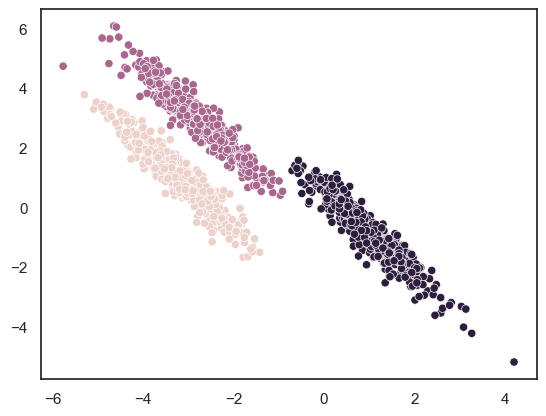

In [10]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=espectral(X, 3, 0.30), legend=False)

## Teste: 4 pontos

In [11]:
def espectral_printador(X, k, sigma):
    print("matriz de afinidade:")
    A = matriz_afinidade(X, sigma)
    print(A)
        
    print("\nmatriz diagonal:")
    D = matriz_diagonal(A)
    print(D)
    
    print("\nlaplaciana:")
    L = D - A
    print(L)
    
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    print("\nlaplaciana normalizada:")
    L = D @ L @ D
    print(L)
    
    autovalores, autovetores = np.linalg.eigh(L)
    print("\nautovalores:", autovalores)
    print("\nautovetores:")
    print(autovetores)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
    print("\nautovetores normalizados:")
    print(V)
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

In [12]:
teste_bobo = np.array([
    [1, 1],
    [2, 2],
    [7, 8],
    [9, 7]
])

matriz de afinidade:
[[0.00000000e+00 3.67879441e-01 3.48726153e-19 1.92874985e-22]
 [3.67879441e-01 0.00000000e+00 5.67568523e-14 8.53304763e-17]
 [3.48726153e-19 5.67568523e-14 0.00000000e+00 8.20849986e-02]
 [1.92874985e-22 8.53304763e-17 8.20849986e-02 0.00000000e+00]]

matriz diagonal:
[[0.36787944 0.         0.         0.        ]
 [0.         0.36787944 0.         0.        ]
 [0.         0.         0.082085   0.        ]
 [0.         0.         0.         0.082085  ]]

laplaciana:
[[ 3.67879441e-01 -3.67879441e-01 -3.48726153e-19 -1.92874985e-22]
 [-3.67879441e-01  3.67879441e-01 -5.67568523e-14 -8.53304763e-17]
 [-3.48726153e-19 -5.67568523e-14  8.20849986e-02 -8.20849986e-02]
 [-1.92874985e-22 -8.53304763e-17 -8.20849986e-02  8.20849986e-02]]

laplaciana normalizada:
[[ 1.00000000e+00 -1.00000000e+00 -2.00678045e-18 -1.10991890e-21]
 [-1.00000000e+00  1.00000000e+00 -3.26613134e-13 -4.91042987e-16]
 [-2.00678045e-18 -3.26613134e-13  1.00000000e+00 -1.00000000e+00]
 [-1.109918

<AxesSubplot: >

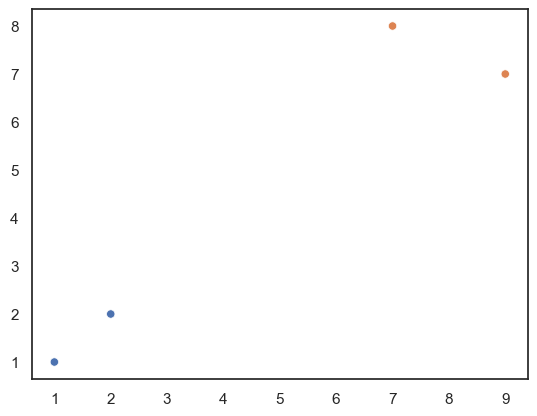

In [13]:
sns.scatterplot(x=teste_bobo[:,0], y=teste_bobo[:,1], hue=espectral_printador(teste_bobo, 2, 1), legend=False)

matriz de afinidade:
[[0.00000000e+00 1.83156389e-02 1.47889751e-74 1.38389653e-87]
 [1.83156389e-02 0.00000000e+00 1.03770332e-53 5.30171867e-65]
 [1.47889751e-74 1.03770332e-53 0.00000000e+00 4.53999298e-05]
 [1.38389653e-87 5.30171867e-65 4.53999298e-05 0.00000000e+00]]

matriz diagonal:
[[1.83156389e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83156389e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.53999298e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.53999298e-05]]

laplaciana:
[[ 1.83156389e-02 -1.83156389e-02 -1.47889751e-74 -1.38389653e-87]
 [-1.83156389e-02  1.83156389e-02 -1.03770332e-53 -5.30171867e-65]
 [-1.47889751e-74 -1.03770332e-53  4.53999298e-05 -4.53999298e-05]
 [-1.38389653e-87 -5.30171867e-65 -4.53999298e-05  4.53999298e-05]]

laplaciana normalizada:
[[ 1.00000000e+00 -1.00000000e+00 -1.62180804e-71 -1.51762682e-84]
 [-1.00000000e+00  1.00000000e+00 -1.13797987e-50 -5.81404049e-62]
 [-1.62180804e

<AxesSubplot: >

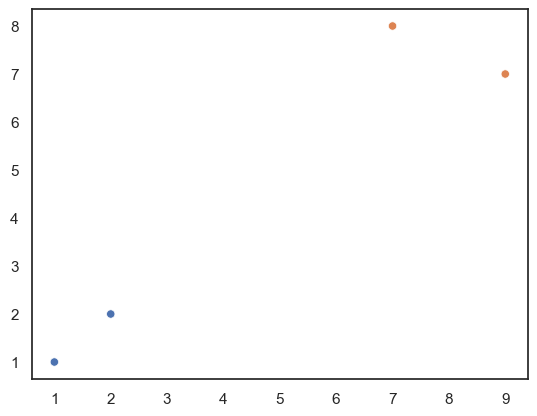

In [14]:
sns.scatterplot(x=teste_bobo[:,0], y=teste_bobo[:,1], hue=espectral_printador(teste_bobo, 2, 0.5), legend=False)

Um sigma menor faz com que conexões distantes fiquem muito fracas.

---

## Modificações: escala local

Para escolher o $\sigma$ ideal, os autores sugerem rodar o algoritmo para diversos valores de $\sigma$.

Isso aumenta o tempo de computação e pode não haver $\sigma$ único que funcione bem para todos os dados.

Ao invés de um  $\sigma$ global, $n$  $\sigma$'s locais são calculados. O critério usado foi a distância para o sétimo vizinho mais próximo.

Intuição para essa modificação: um vértice que está perto de muitos outros vai ter um $\sigma$ pequeno, o que fará com que a distância para vértices distantes decaia muito

## Versão #2: $\sigma$ automático e local

In [15]:
def matriz_afinidade2(X):
    n = X.shape[0]    
    dist = distance.cdist(X, X, metric="sqeuclidean")
    # dist = np.zeros((n, n))
    # for i in range(n):
    #     for j in range(i+1, n):
    #         dist[i, j] = dist[j, i] = np.linalg.norm(X[j] - X[i])
    
    sigmas = np.zeros(n)
    for i in range(n):
        sigmas[i] = sorted(dist[i])[7]
    
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = np.exp(-dist[i, j]**2 / (sigmas[i] * sigmas[j]))
            A[i, j] = A[j, i] = d
    
    return A

In [16]:
def espectral2(X, k):
    A = matriz_afinidade2(X)
    D = matriz_diagonal(A)
    
    L = D - A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    _, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
        
    return KMeans(n_clusters=k, n_init="auto", random_state=RS).fit_predict(V)

<AxesSubplot: >

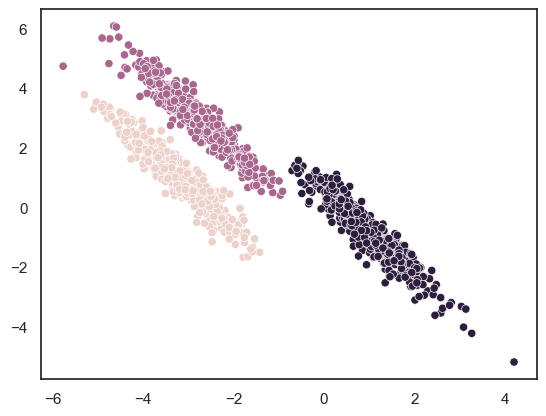

In [17]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=espectral2(X, 3), legend=False)

---

## Transformando em classes

In [18]:
class Espectral:
    def __init__(self, k, sigma):
        self.k = k
        self.sigma = sigma
        
    def fit_predict(self, X):
        return espectral(X, self.k, self.sigma)

In [19]:
class Espectral2:
    def __init__(self, k):
        self.k = k
    
    def fit_predict(self, X):
        return espectral2(X, self.k)

---

## Visualizando a transformação dos dados

In [20]:
from sklearn.datasets import make_moons, make_circles

In [21]:
def base_espectral(X, k, grupos):
    A = matriz_afinidade2(X)
    D = matriz_diagonal(A)
    
    L = D - A
    
    D = np.linalg.pinv(D)
    D = fractional_matrix_power(D, 1/2)
    
    L = D @ L @ D
    
    _, autovetores = np.linalg.eigh(L)
    V = autovetores[:, :k]
    
    for i in range(len(V)):
        V[i] /= np.linalg.norm(V[i])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=grupos, legend=False, ax=axes[0])
    sns.scatterplot(x=V[:,0], y=V[:,1], hue=grupos, legend=False, ax=axes[1])

In [22]:
circulos, grupos = make_circles(n_samples=500, noise=0.01, random_state=RS)

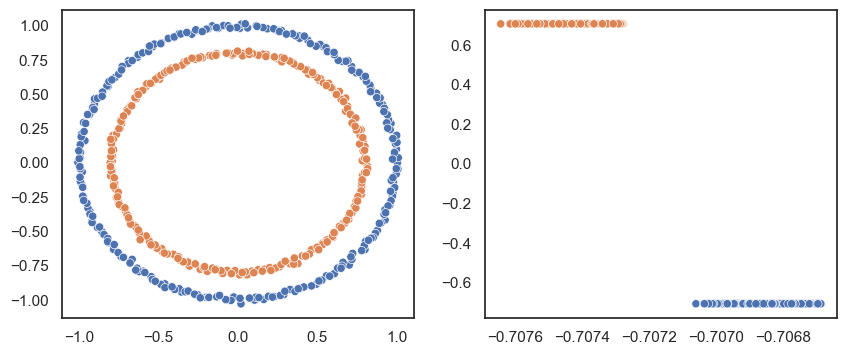

In [23]:
base_espectral(circulos, 2, grupos)

In [24]:
luas, grupos = make_moons(n_samples=300, noise=0.05, random_state=RS)

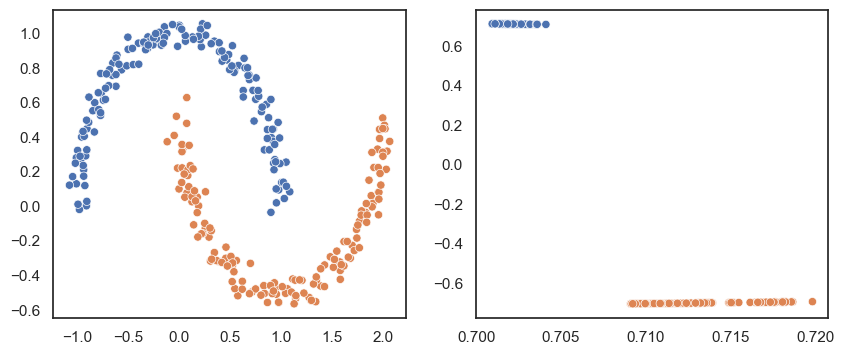

In [25]:
base_espectral(luas, 2, grupos)

---

## Automatizando a testagem

In [26]:
def testa_clusterizacao(algoritmo, parametros):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    luas = make_moons(n_samples=1000, noise=0.05, random_state=RS)[0]
    
    c1 = make_circles(n_samples=500, noise=0.01, random_state=RS)[0]
    c2 = make_circles(n_samples=500, noise=0.01, random_state=RS)[0] * 1.5
    circulos = np.concatenate([c1, c2])
    
    for pontos, ax, param in zip([X, luas, circulos], axes, parametros):
        instancia = algoritmo(**param)
        sns.scatterplot(x=pontos[:,0], y=pontos[:,1], hue=instancia.fit_predict(pontos), palette="tab10", legend=False, ax=ax)

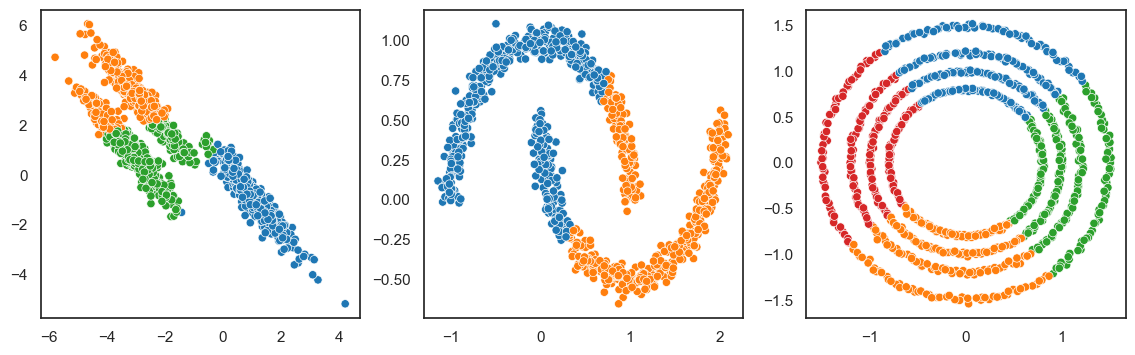

In [27]:
testa_clusterizacao(
    KMeans,
    [
        {"n_clusters": 3, "n_init": "auto"},
        {"n_clusters": 2, "n_init": "auto"},
        {"n_clusters": 4, "n_init": "auto"}
    ]
)

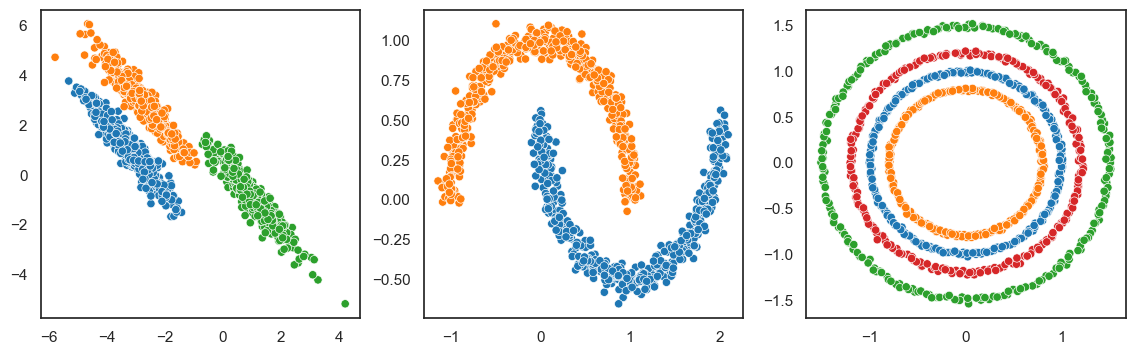

In [28]:
testa_clusterizacao(
    Espectral,
    [
        {"k": 3, "sigma": 0.31},
        {"k": 2, "sigma": 0.12},
        {"k": 4, "sigma": 0.02},
    ]
)

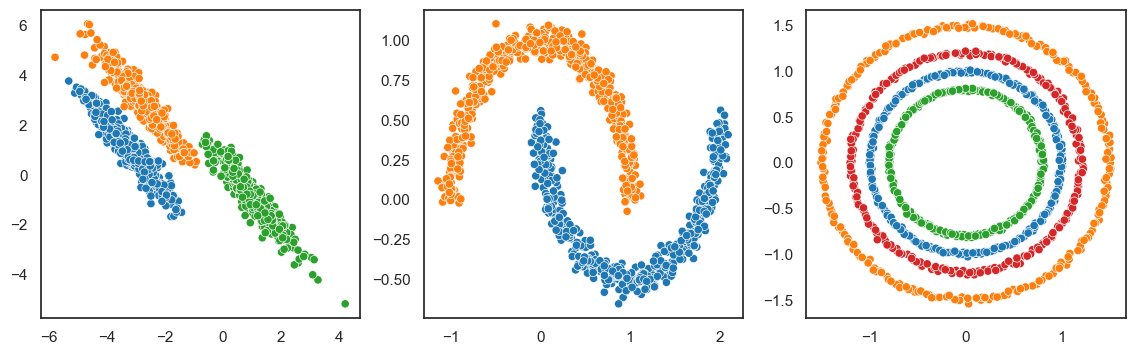

In [29]:
testa_clusterizacao(
    Espectral2,
    [
        {"k": 3},
        {"k": 2},
        {"k": 4},
    ]
)

---

## Testes adicionais

In [31]:
import pandas as pd

In [92]:
def testa_clusterizacao2(X, algoritmo):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(X, x="x", y="y", hue="color", palette="tab10", legend=False, ax=axes[0])
    sns.scatterplot(X, x="x", y="y", hue=algoritmo.fit_predict(X[["x", "y"]]), palette="tab10", legend=False, ax=axes[1])
    axes[0].set(xlabel=None, ylabel=None)
    axes[1].set(xlabel=None, ylabel=None)

In [76]:
face = pd.read_csv("testes/face.csv")
len(face)

1273

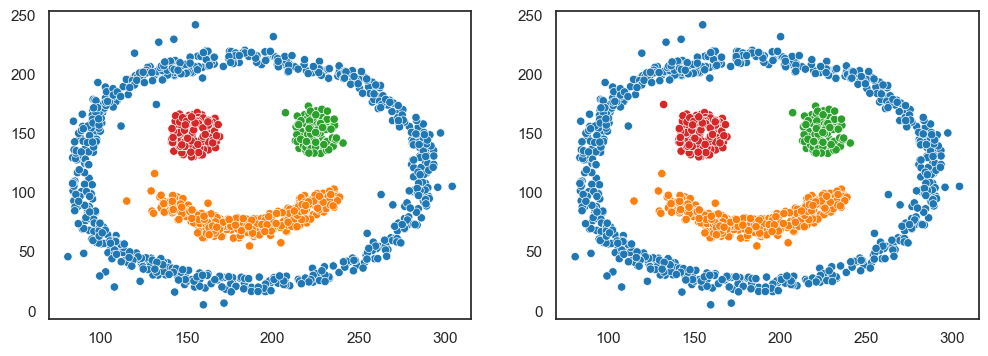

In [95]:
testa_clusterizacao2(face, Espectral2(4))

In [81]:
un2 = pd.read_csv("testes/un2.csv")
len(un2)

6202

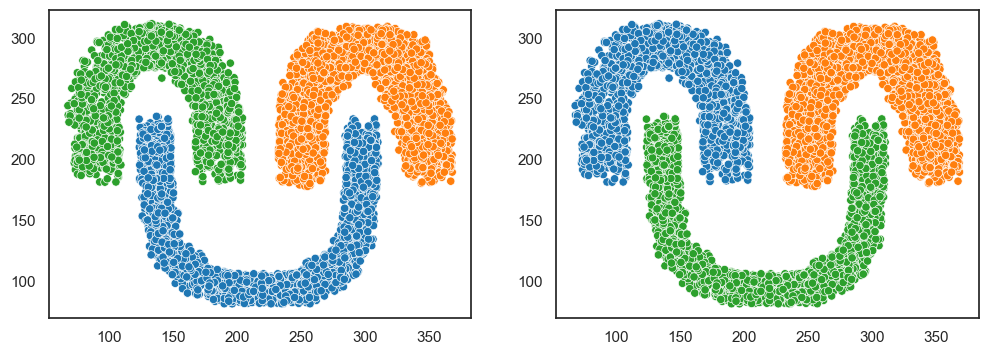

In [82]:
# testa_clusterizacao2(un2, Espectral2(3)) # 406 segundos!

In [83]:
supernova = pd.read_csv("testes/supernova.csv")
len(supernova)

10714

<AxesSubplot: xlabel='x', ylabel='y'>

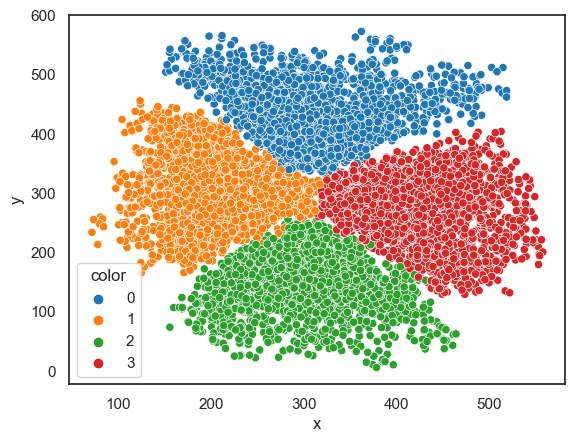

In [85]:
sns.scatterplot(supernova, x="x", y="y", hue="color", palette="tab10")

In [87]:
remove_n = 8714
indices = np.random.choice(supernova.index, remove_n, replace=False)
supernova = supernova.drop(indices)

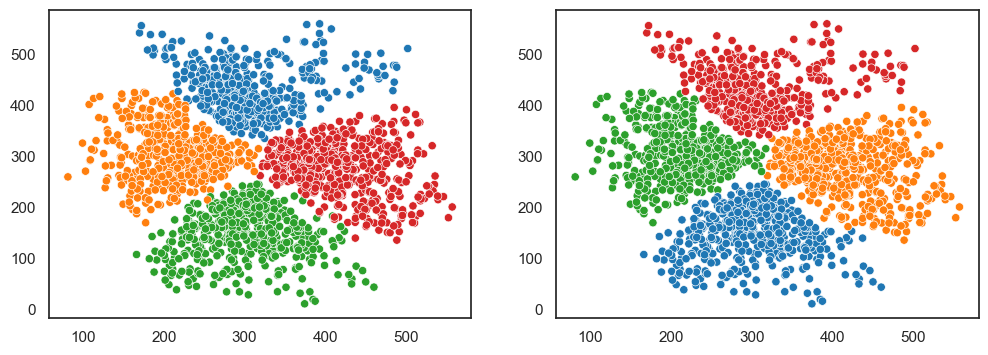

In [96]:
testa_clusterizacao2(supernova, Espectral2(4))

C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


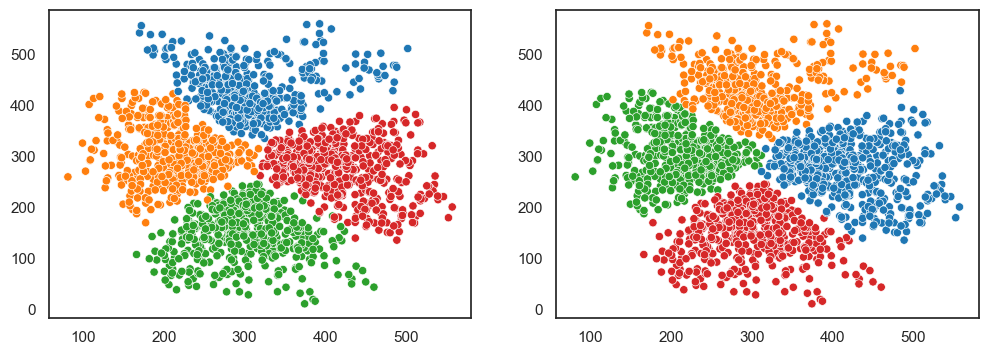

In [99]:
testa_clusterizacao2(supernova, KMeans(4))

In [90]:
isolation = pd.read_csv("testes/isolation.csv")
len(isolation)

464

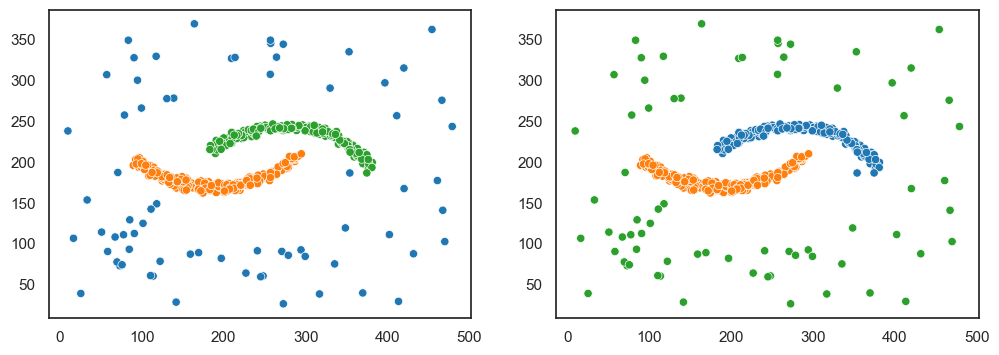

In [97]:
testa_clusterizacao2(isolation, Espectral2(3))

C:\Users\Mathe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


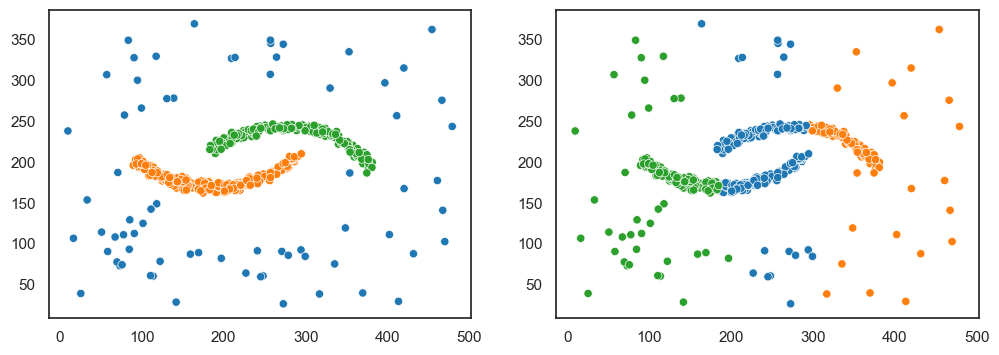

In [98]:
testa_clusterizacao2(isolation, KMeans(3))

In [102]:
outliers = pd.read_csv("testes/outliers.csv")
len(outliers)

876

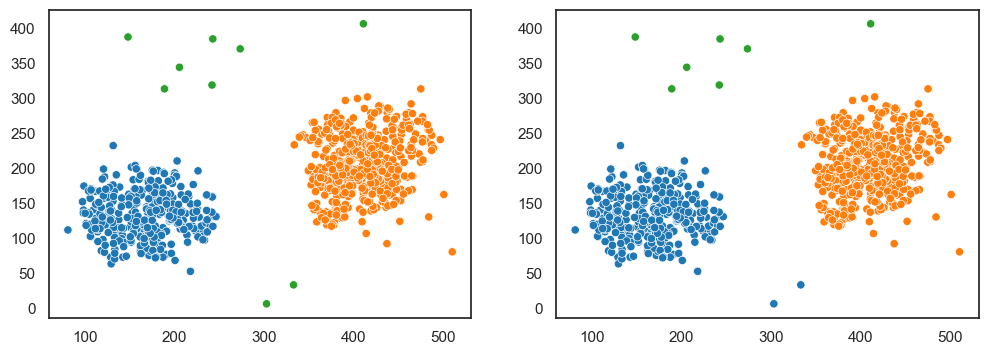

In [103]:
testa_clusterizacao2(outliers, Espectral2(3))

---

referencias
- [On Spectral Clusteting: Analysis and an Algorithm](https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf) - Ng, Jordan, Weiss
- [Self-Tuning Spectral Clustering](https://proceedings.neurips.cc/paper_files/paper/2004/file/40173ea48d9567f1f393b20c855bb40b-Paper.pdf) - Zelnik-Manor, Perona
- [Implementing Self-Tuning Spectral Clustering](https://huiwenn.github.io/spectral-clustering)
- [3 Easy Steps to Understand and Implement Spectral Clustering in Python](https://www.youtube.com/watch?v=YHz0PHcuJnk)
- [A tutorial on spectral clustering](https://sci-hub.se/https://link.springer.com/article/10.1007/s11222-007-9033-z)